In [1]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.ticker as mticker

from glob import glob
import cartopy.crs as ccrs
import xarray as xr
import numpy as np
import string

import contextily as cx
import geopandas as gpd
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
from shapely.geometry.point import Point

from pyresample.geometry import SwathDefinition
from scipy.spatial import ConvexHull
from shapely import geometry


font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

In [2]:
data_dir = '../data/ch4_cases/Azerbaijan/'


ds_osm = xr.open_mfdataset(glob(data_dir+'/OSM/*L2*nc')[0], decode_coords='all')
ds_gshhg = xr.open_mfdataset(glob(data_dir+'/GSHHG/*L2*nc')[0], decode_coords='all')
ds_natural_earth = xr.open_mfdataset(glob(data_dir+'/Natural_Earth/*L2*nc')[0], decode_coords='all')
ds_cluster = xr.open_mfdataset(glob(data_dir+'/cluster/*L2*nc')[0], decode_coords='all')

In [3]:
def subset(data, lon_min, lon_max, lat_min, lat_max, onlywater=False):
    data = data.load()
    data = data.where((data['longitude']>lon_min)&(data['longitude']<lon_max)&(data['latitude']>lat_min)&(data['latitude']<lat_max))
    if onlywater:
        data = data.where(data==0, drop=True)

    return data

In [4]:
def add_scalebar(ax, longitude, latitude, scale_bar_location='lower right'):
    # Geographic WGS 84 - degrees
    scale_points = gpd.GeoSeries([Point(longitude-1, latitude),
                                  Point(longitude, latitude)],
                                 crs=4326)
    # UTM projection
    utm_crs_list = query_utm_crs_info(
        datum_name='WGS 84',
        area_of_interest=AreaOfInterest(
            west_lon_degree=longitude,
            south_lat_degree=latitude,
            east_lon_degree=longitude,
            north_lat_degree=latitude,
        ),
    )
    utm_epsg = CRS.from_epsg(utm_crs_list[0].code).to_epsg()

    # Projected WGS 84 - meters
    scale_points = scale_points.to_crs(utm_epsg)
    distance_meters = scale_points[0].distance(scale_points[1])
    
    scalebar = ScaleBar(distance_meters,
                        location=scale_bar_location,
                        color='white',
                        box_alpha=0,
                        font_properties={'size': 10},
                        )

    ax.add_artist(scalebar)

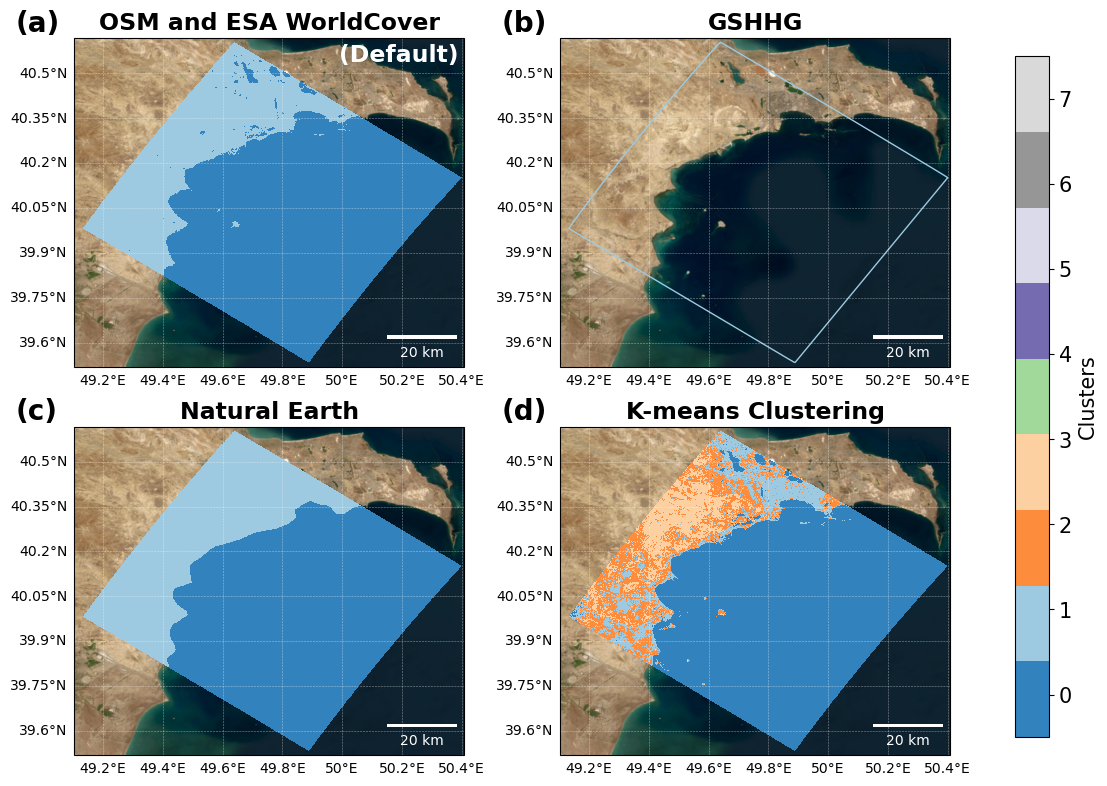

In [5]:
# set center
# plume_longitude = 49.601544
# plume_latitude = 40.246876
# longitude_center = ds_cluster['longitude'].mean()
# latitude_center = ds_cluster['latitude'].mean()
# pad = 0.5

proj = ccrs.PlateCarree()

fig, axs = plt.subplots(nrows=2,ncols=2,
                        sharex=True, sharey=True,
                        subplot_kw={'projection': proj},
                        figsize=(11, 10),
                        layout='compressed',
                       )

axs = axs.flatten()

# set extent
lon_min = ds_cluster['longitude'].min().values # longitude_center - pad
lon_max = ds_cluster['longitude'].max().values # longitude_center + pad
lat_min = ds_cluster['latitude'].min().values # latitude_center - pad
lat_max = ds_cluster['latitude'].max().values # latitude_center + pad
extent = (lon_min, lon_max, lat_min, lat_max)

for ax in axs:
    ax.set_extent(extent, crs=proj)

    # add high-res background
    cx.add_basemap(ax, crs=proj, source=cx.providers.Esri.WorldImagery)
    # remove watermark
    ax.texts[0].remove()

# Define a colormap with only blue for value 1
cmap = mcolors.ListedColormap(['#3182bd', '#9dcae0'])
bounds = [-0.5, 0.5, 1.5]  # Define color boundaries
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# --- clusters ---
ax = axs[0]
seg_osm = subset(ds_osm['segmentation'], lon_min, lon_max, lat_min, lat_max)
seg_osm.plot(ax=ax, x='longitude', y='latitude', cmap=cmap, norm=norm, add_colorbar=False, rasterized=True)
# seg_osm.plot.contour(ax=ax, x='longitude', y='latitude', levels=[0, 1], cmap='autumn')#, add_colorbar=False)
ax.set_title('OSM and ESA WorldCover')

ax = axs[1]
seg_gshhg = subset(ds_gshhg['segmentation'], lon_min, lon_max, lat_min, lat_max, onlywater=True)
if seg_gshhg.any():
    seg_gshhg.plot(ax=ax, x='longitude', y='latitude', cmap=cmap, norm=norm, add_colorbar=False, rasterized=True)
else:
    # get the swath polygon from area boundary
    valid_pixels = ds_osm['segmentation'].stack(z=['y', 'x']).dropna(dim='z')
    area = SwathDefinition(lons=valid_pixels['longitude'].values[:,np.newaxis], lats=valid_pixels['latitude'].values[:,np.newaxis])
    hull = ConvexHull(area.boundary().vertices)
    edgePoly = geometry.Polygon(hull.points[hull.vertices])
    ax.add_geometries([edgePoly], crs=proj, edgecolor='#9dcae0', facecolor='none')
    
ax.set_title('GSHHG')

ax = axs[2]
seg_natural_earth = subset(ds_natural_earth['segmentation'], lon_min, lon_max, lat_min, lat_max)
if seg_natural_earth.any():
    seg_natural_earth.plot(ax=ax, x='longitude', y='latitude', cmap=cmap, norm=norm, add_colorbar=False, rasterized=True)
ax.set_title('Natural Earth')

ax = axs[3]
seg_cluster = subset(ds_cluster['segmentation'], lon_min, lon_max, lat_min, lat_max, onlywater=False)
n_clusters = len(np.unique(ds_cluster['segmentation']))
cmap_cluster = plt.get_cmap('tab20c', n_clusters)

m = seg_cluster.plot(ax=ax, x='longitude', y='latitude',
                     cmap=cmap_cluster,
                     vmin = ds_cluster['segmentation'].min() - 0.5,
                     vmax = ds_cluster['segmentation'].max() + 0.5,
                     add_colorbar=False, rasterized=True)
ax.set_title('K-means Clustering')


for ax in axs:
    add_scalebar(ax, ds_cluster['longitude'].mean(), ds_cluster['latitude'].mean())

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.4, color='w', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False


# add colorbar
cbar = fig.colorbar(m, ticks=np.arange(ds_cluster['segmentation'].min(), ds_cluster['segmentation'].max() + 1),
                    ax=axs, label='Clusters', shrink=0.95)

for n, ax in enumerate(axs):
    ax.text(-0.15, 1.02, '({})'.format(string.ascii_lowercase[n]),
            transform=ax.transAxes, 
            size=20, weight='bold')

axs[0].text(0.68, 0.93, '(Default)',
            transform=axs[0].transAxes, c='w',
            size=17, weight='bold')

fig.savefig('../figures/clusters.pdf', bbox_inches='tight')

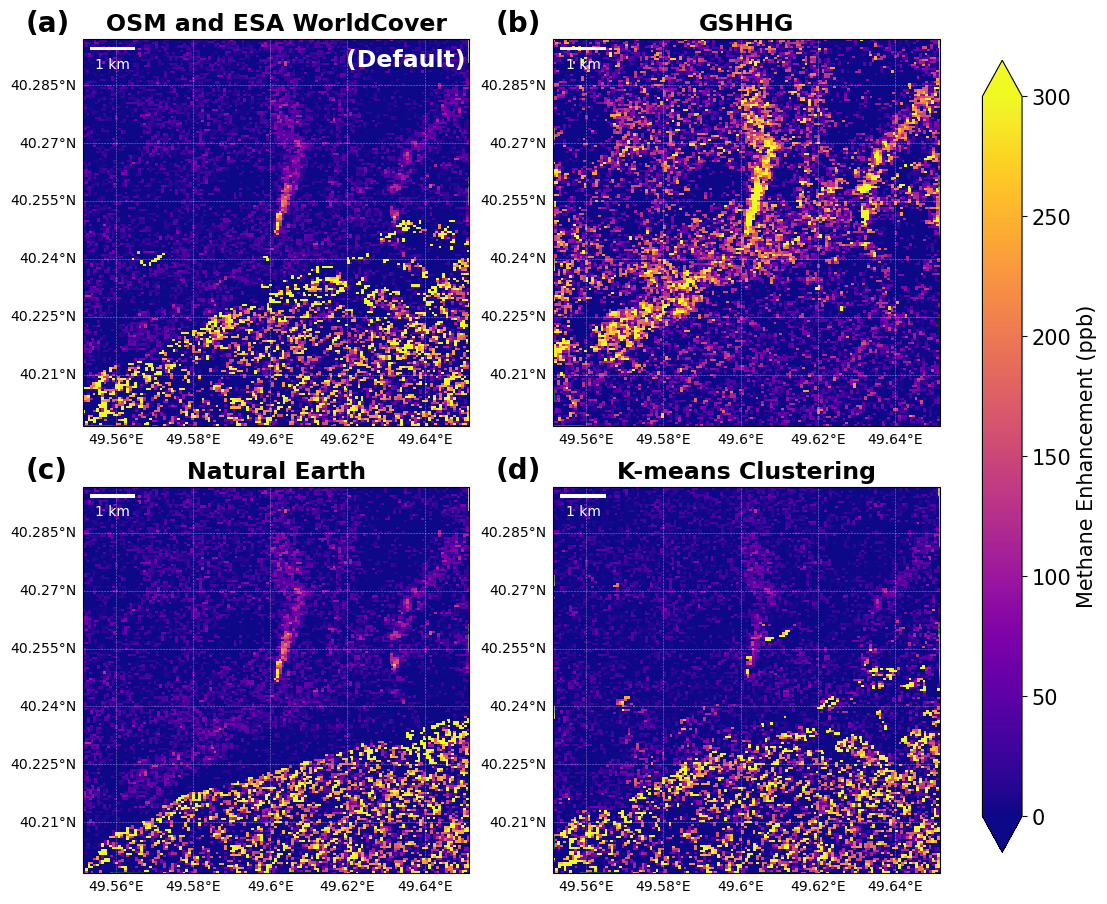

In [6]:
fig, axs = plt.subplots(nrows=2,ncols=2,
                        sharex=True, sharey=True,
                        subplot_kw={'projection': proj},
                        figsize=(11, 10),
                        layout='compressed',
                       )

axs = axs.flatten()

# set extent
plume_longitude = 49.601544
plume_latitude = 40.246876
pad = 0.05
vmax = 300

lon_min = plume_longitude - pad
lon_max = plume_longitude + pad
lat_min = plume_latitude - pad
lat_max = plume_latitude + pad
extent = (lon_min, lon_max, lat_min, lat_max)

for ax in axs:
    ax.set_extent(extent, crs=proj)

    # add high-res background
    cx.add_basemap(ax, crs=proj, source=cx.providers.Esri.WorldImagery)
    # remove watermark
    ax.texts[0].remove()


# --- clusters ---
ax = axs[0]
ch4_osm = subset(ds_osm['ch4'], lon_min, lon_max, lat_min, lat_max, onlywater=False)
ch4_osm.plot(ax=ax, x='longitude', y='latitude',
             vmin=0, vmax=vmax, cmap='plasma',
             add_colorbar=False, rasterized=True
            )
# seg_osm.plot.contour(ax=ax, x='longitude', y='latitude', levels=[0, 1], cmap='autumn')#, add_colorbar=False)
ax.set_title('OSM and ESA WorldCover')

ax = axs[1]
ch4_gshhg = subset(ds_gshhg['ch4'], lon_min, lon_max, lat_min, lat_max, onlywater=False)
ch4_gshhg.plot(ax=ax, x='longitude', y='latitude',
         vmin=0, vmax=vmax, cmap='plasma',
         add_colorbar=False, rasterized=True
        )
ax.set_title('GSHHG')

ax = axs[2]
ch4_natural_earth = subset(ds_natural_earth['ch4'], lon_min, lon_max, lat_min, lat_max, onlywater=False)
ch4_natural_earth.plot(ax=ax, x='longitude', y='latitude',
         vmin=0, vmax=vmax, cmap='plasma',
         add_colorbar=False, rasterized=True
        )
ax.set_title('Natural Earth')

ax = axs[3]
ch4_cluster = subset(ds_cluster['ch4'], lon_min, lon_max, lat_min, lat_max, onlywater=False)
m = ch4_cluster.plot(ax=ax, x='longitude', y='latitude',
         vmin=0, vmax=vmax, cmap='plasma',
         add_colorbar=False, rasterized=True
        )
ax.set_title('K-means Clustering')

for ax in axs:
    add_scalebar(ax, ds_cluster['longitude'].mean(), ds_cluster['latitude'].mean(), scale_bar_location='upper left')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.4, color='w', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.MaxNLocator(5)

# add colorbar
cbar = fig.colorbar(m, ax=axs, extend='both', label='Methane Enhancement (ppb)', shrink=0.95)

for n, ax in enumerate(axs):
    ax.text(-0.15, 1.02, '({})'.format(string.ascii_lowercase[n]),
            transform=ax.transAxes, 
            size=20, weight='bold')

axs[0].text(0.68, 0.93, '(Default)',
            transform=axs[0].transAxes, c='w',
            size=17, weight='bold')

fig.savefig('../figures/ch4_clusters.pdf', bbox_inches='tight')